# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [389]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [390]:
data = pd.read_csv('train.csv')

In [391]:
data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [392]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [395]:
train_filled = train.fillna("")
test_filled = test.fillna("")

print(f'NaNs in train: {train_filled.isna().sum().sum()}')
print(f'NaNs in test: {test_filled.isna().sum().sum()}')

NaNs in train: 0
NaNs in test: 0


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [396]:
grouped_train = train_filled.groupby('target')['target'].agg(['count'])

display(grouped_train)

negative = grouped_train['count'][0]
positive = grouped_train['count'][1]

print(f'part of negatives: {negative / (negative + positive)}')
print(f'part of positives: {positive / (negative + positive)}')

,count
target,
0,3024
1,2305


part of negatives: 0.5674610621129668
part of positives: 0.43253893788703324


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [397]:
most_frequent = train_filled['keyword'].value_counts()[1:11].index.tolist() # самой частой оказалась пустая строка
most_frequent

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'refugees',
 'derail',
 'fear',
 'tsunami',
 'fatality']

In [398]:
group_by_keyword_and_target = train_filled.groupby(['keyword', 'target'])['keyword'].count()

group_by_keyword_and_target

keyword   target
          0         12
          1         32
ablaze    0         16
          1          4
accident  0          6
                    ..
wreck     0         21
          1          4
wreckage  1         34
wrecked   0         25
          1          1
Name: keyword, Length: 434, dtype: int64

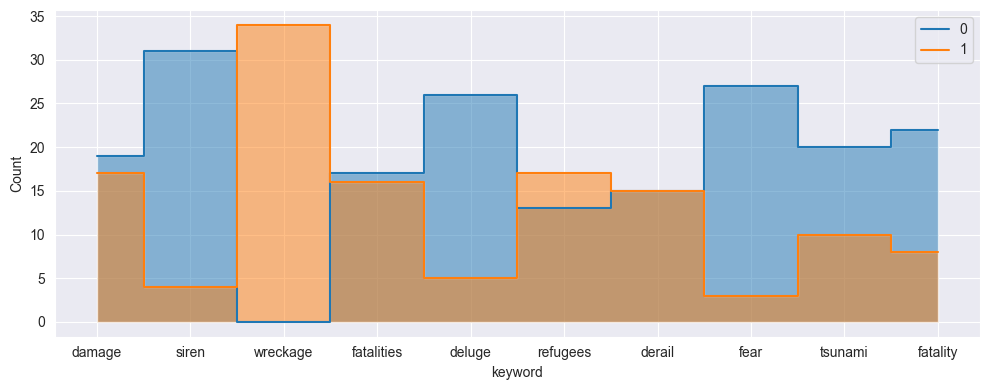

In [399]:
negatives = []
positives = []

index = group_by_keyword_and_target.loc

for word in most_frequent:
    try:
        negatives.append(index[word][0])
    except KeyError:
        negatives.append(0)

    try:
        positives.append(index[word][1])
    except KeyError:
        positives.append(0)

figure = plt.figure(figsize=(10, 4))

plt.fill_between(most_frequent, negatives, step='mid', alpha=0.5)
plt.fill_between(most_frequent, positives, step='mid', alpha=0.5)

plt.step(
    x=most_frequent,
    y=negatives,
    label='0',
    where='mid',
)

plt.step(
    x=most_frequent,
    y=positives,
    label='1',
    where='mid'
)

plt.ylabel('Count')
plt.xlabel('keyword')

plt.tight_layout()
plt.legend()

plt.show()

**Выводы**:
если твит содержит упоминание `wreckage` (крушение? обломки?), то как будто бы катастрофа 100% случилась, но скорее всего просто отрицательные классы не попали в выборку
также можно заметить, что если твит содержит упоминание `siren`, `deluge` или `fear`, то маловероятно, что катастрофа настоящая. Сирены могут быть учебными, потопы могут быть от соседей :)
В целом, еще можно заметить, что большинство твитов не содержат информацию о настоящей катастрофе

а еще я ненавижу строить графики

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [400]:
train_filled.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [401]:
train_new = pd.DataFrame()
train_new['text'] = train_filled[['keyword', 'location', 'text']].agg(' '.join, axis=1)
train_new['target'] = train_filled['target']

train_new

,text,target
1186,bridge%20collapse Ashes 2015: AustraliaÛªs c...,0
4071,"hail Carol Stream, Illinois GREAT MICHIGAN TEC...",1
5461,police Houston CNN: Tennessee movie theater s...,1
5787,rioting Still rioting in a couple of hours le...,1
7445,wounds Lake Highlands Crack in the path where ...,0
...,...,...
5226,obliteration Merica! @Eganator2000 There aren'...,0
5390,panic just had a panic attack bc I don't have...,0
860,blood Omron HEM-712C Automatic Blood Pressure...,0
7603,Officials say a quarantine is in place at an...,1


In [402]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [403]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_new.text)

In [404]:
X

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [405]:
import re
from string import punctuation

In [409]:
punctuation_set = set(punctuation)

def contains_digit(s: str) -> bool:
    return any(char.isdigit() for char in s)

def contains_punctuation(s: str) -> bool:
    return any(char in punctuation_set for char in s)

def is_hashtag(s: str) -> bool:
    return len(s) != 0 and s[0] == '#'

def is_mention(s: str) -> bool:
    return len(s) != 0 and s[0] == '@'

def investigate_vocabulary(vocabulary):
    # -- YOUR CODE HERE --
    print('With digit:      ', sum([contains_digit(s) for s in vocabulary.keys()]))

    print('With punctuation:', sum([contains_punctuation(s) for s in vocabulary.keys()]))

    print('Hashtags:        ', sum([is_hashtag(s) for s in vocabulary.keys()]))

    print('Mentions:        ', sum([is_mention(s) for s in vocabulary.keys()]))




In [410]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [411]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [412]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [413]:
def tokenizer(text):
    tok = TweetTokenizer()
    return tok.tokenize(text)

tweet_vectorizer = CountVectorizer(tokenizer=tokenizer)

tweet_X = tweet_vectorizer.fit_transform(train_new.text)

tweet_X

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [279]:
investigate_vocabulary(tweet_vectorizer.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** `TweeTokenizer` нашёл всего больше)) в случае с хэштегами и упоминаниями, скорее всего в одном токене с ними есть еще обычный текст перемешаны с обычным текстом в одном токене

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [443]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download("stopwords", quiet=True)
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [444]:
stopwords = set(stopwords.words('english'))

def contains_only_latin_letters(s: str) -> bool:
    return all(char.isalpha() and char.isascii() for char in s)

def is_emoji(s: str) -> bool:
    bracket_counter = 0

    for char in s:
        if char == ')' or char == '(':
            bracket_counter += 1
        elif char not in punctuation_set:
            return False

    return bracket_counter > 0

def is_hashtag(s: str) -> bool:
    return len(s) > 1 and s[0] == '#' and all(char.isalpha() for char in s[1:])

def custom_tokenizer(s: str) -> List[str]:
    stemmer = SnowballStemmer('english')
    tokenizer = TweetTokenizer()
    tokenized_str = tokenizer.tokenize(s.lower())

    result = []
    for token in tokenized_str:
        if token not in stopwords and (contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token)):
            result.append(stemmer.stem(token))

    return result


In [445]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [446]:
for i in range(0, 10):
    text = train_new['text'].iloc[i]
    print(custom_tokenizer(text))

['bridg', 'ash', 'australia', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', 'england', 'bundl', 'australia']
['hail', 'carol', 'stream', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'thank', '#goblu', '#wrestleon']
['polic', 'houston', 'cnn', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee']
['airplan', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', 'french', 'air', 'accid', 'expert', '#mlb']
['bloodi', 'isol', 'citi', 'world', 'perth', 'came', 'kill', 'indian', 'fun', 'video', 'smirk', 'remorseless', 'pakistani', 'killer', 'show', 'boast']
['burn', 'except', 'idk', 'realli', 'burn']
['destroy', '(', 'ask', ')', 'destroy', 'hous']
['wound', 'maracay', 'nirgua', 'venezuela', 'polic', 'offic', 'wound', 'suspect

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [447]:
test_new = pd.DataFrame()
test_new['text'] = test_filled[['keyword', 'location', 'text']].agg(' '.join, axis=1)
test_new['target'] = test_filled['target']

test_new

,text,target
2644,destruction So you have a new weapon that can...,1
2227,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,police UK DT @georgegalloway: RT @Galloway4May...,1
132,aftershock Aftershock back to school kick off...,0
6845,"trauma Montgomery County, MD in response to tr...",0
...,...,...
4307,"hellfire 570 Vanderbilt; Brooklyn, NY New cock...",0
3375,evacuation USA Bend Post Office roofers cut ga...,1
1710,collided Monsoon flooding - Monsoon rains hav...,1
4898,massacre Ireland Remember this was a massacre ...,1


In [448]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

tokenized_train = vectorizer.fit_transform(train_new.text)
tokenized_test = vectorizer.transform(test_new.text)

display(tokenized_train)
display(tokenized_test)

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x10485 sparse matrix of type '<class 'numpy.int64'>'
	with 50925 stored elements in Compressed Sparse Row format>

<2284x10485 sparse matrix of type '<class 'numpy.int64'>'
	with 19275 stored elements in Compressed Sparse Row format>

2. Обучите LogisticRegression на полученных признаках.


In [449]:
from sklearn.linear_model import LogisticRegression

Y_train = train_new['target']
Y_test = test_new['target']

logreg = LogisticRegression(random_state=42).fit(tokenized_train, Y_train)

prediction = logreg.predict(tokenized_test)

3. Посчитайте метрику f1-score на тестовых данных.

In [450]:
from sklearn.metrics import f1_score

print(f'F1 score: {f1_score(Y_test, prediction)}')

F1 score: 0.7533584094572812


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [451]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

tf_idf_train = tf_idf_vectorizer.fit_transform(train_new.text)
tf_idf_test = tf_idf_vectorizer.transform(test_new.text)

display(tf_idf_train)
display(tf_idf_test)

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x10485 sparse matrix of type '<class 'numpy.float64'>'
	with 50925 stored elements in Compressed Sparse Row format>

<2284x10485 sparse matrix of type '<class 'numpy.float64'>'
	with 19275 stored elements in Compressed Sparse Row format>

In [452]:
tf_idf_logreg = LogisticRegression(random_state=42).fit(tf_idf_train, Y_train)

prediction = tf_idf_logreg.predict(tf_idf_test)

print(f'F1 score: {f1_score(Y_test, prediction)}')

F1 score: 0.7429205996668518


1. **Ответ:** score незначительно уменьшился

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [453]:
tf_idf_vectorizer = TfidfVectorizer(max_df=0.9, tokenizer=custom_tokenizer)

tf_idf_train = tf_idf_vectorizer.fit_transform(train_new.text)
tf_idf_test = tf_idf_vectorizer.transform(test_new.text)

display(tf_idf_train)
display(tf_idf_test)

tf_idf_logreg = LogisticRegression(random_state=42).fit(tf_idf_train, Y_train)

prediction = tf_idf_logreg.predict(tf_idf_test)

print(f'F1 score: {f1_score(Y_test, prediction)}')

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x10485 sparse matrix of type '<class 'numpy.float64'>'
	with 50925 stored elements in Compressed Sparse Row format>

<2284x10485 sparse matrix of type '<class 'numpy.float64'>'
	with 19275 stored elements in Compressed Sparse Row format>

F1 score: 0.7429205996668518


2. **Ответ:** Рофла не понял, ничего не поменялось..

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [454]:
tf_idf_vectorizer = TfidfVectorizer(
    min_df=0.001,
    max_df=0.9,
    tokenizer=custom_tokenizer
)

tf_idf_train = tf_idf_vectorizer.fit_transform(train_new.text)
tf_idf_test = tf_idf_vectorizer.transform(test_new.text)

display(tf_idf_train)
display(tf_idf_test)

tf_idf_logreg = LogisticRegression(random_state=42).fit(tf_idf_train, Y_train)

prediction = tf_idf_logreg.predict(tf_idf_test)

print(f'F1 score: {f1_score(Y_test, prediction)}')

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x1740 sparse matrix of type '<class 'numpy.float64'>'
	with 37026 stored elements in Compressed Sparse Row format>

<2284x1740 sparse matrix of type '<class 'numpy.float64'>'
	with 15224 stored elements in Compressed Sparse Row format>

F1 score: 0.7445175438596492


3. **Ответ:** у всех токенов слишком низкий df, увеличение скора начинается только примерно с `min_df` = 0.001

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [455]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(n_features=5000, tokenizer=custom_tokenizer)

hash_train = hash_vectorizer.fit_transform(train_new.text)
hash_test = hash_vectorizer.transform(test_new.text)

display(hash_train)
display(hash_test)

hash_logreg = LogisticRegression(random_state=42).fit(hash_train, Y_train)

hash_prediction = hash_logreg.predict(hash_test)

print(f'F1 score: {f1_score(Y_test, hash_prediction)}')

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 50887 stored elements in Compressed Sparse Row format>

<2284x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 21798 stored elements in Compressed Sparse Row format>

F1 score: 0.7194645844952593


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Пока что предыдущий подход самый лучший :/

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [456]:
tf_idf_vectorizer = TfidfVectorizer(
    min_df=0.001,
    max_df=0.1,
    tokenizer=custom_tokenizer
)

tf_idf_train = tf_idf_vectorizer.fit_transform(train_new.text)
tf_idf_test = tf_idf_vectorizer.transform(test_new.text)

display(tf_idf_train)
display(tf_idf_test)

tf_idf_logreg = LogisticRegression(random_state=42).fit(tf_idf_train, Y_train)

prediction = tf_idf_logreg.predict(tf_idf_test)

print(f'F1 score: {f1_score(Y_test, prediction)}')

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x1740 sparse matrix of type '<class 'numpy.float64'>'
	with 37026 stored elements in Compressed Sparse Row format>

<2284x1740 sparse matrix of type '<class 'numpy.float64'>'
	with 15224 stored elements in Compressed Sparse Row format>

F1 score: 0.7445175438596492


Это максимум, что я смог выжать с tf-idf :(
Не знаю, можно ли использовать BOW, но если да, то там будет 0,75:

In [457]:
bow_vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
bow_train = bow_vectorizer.fit_transform(train_new.text)
bow_test = bow_vectorizer.transform(test_new.text)

display(bow_train)
display(bow_test)

bow_logreg = LogisticRegression(random_state=42).fit(bow_train, Y_train)

prediction = bow_logreg.predict(bow_test)

print(f'F1 score: {f1_score(Y_test, prediction)}')

C:\Users\user\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<5329x10485 sparse matrix of type '<class 'numpy.int64'>'
	with 50925 stored elements in Compressed Sparse Row format>

<2284x10485 sparse matrix of type '<class 'numpy.int64'>'
	with 19275 stored elements in Compressed Sparse Row format>

F1 score: 0.7533584094572812


![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7e/%D0%AD%D1%82%D0%BE_%D0%BD%D0%B5%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%2C_%D0%BD%D0%BE_%D1%8D%D1%82%D0%BE_%D1%87%D0%B5%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.jpg/1200px-%D0%AD%D1%82%D0%BE_%D0%BD%D0%B5%D0%BC%D0%BD%D0%BE%D0%B3%D0%BE%2C_%D0%BD%D0%BE_%D1%8D%D1%82%D0%BE_%D1%87%D0%B5%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.jpg)